# Volume 4: Optimal Control as Boundary Value Problems

In [121]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from functools import partial
import matplotlib.animation as animation

In [32]:
def obstacle(x,y,W1=1,r=(1,1),c=(0,0)):
    '''
    Define an area that will represent an obstacle
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    ellipse = ((x - c[0])**2/r[0] + (y - c[1])**2/r[1])**20 + 1

    return W1 / ellipse

def obstacle_dx(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    x derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40* W1 * (x-c[0])*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    y derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2

    return numer / denom

tf:  3.716697422078728


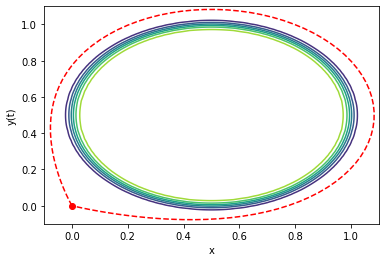

In [132]:
def prob4():
    '''
    Find the optimal path and time for the free time horizon problem.
    Plot the solution and return the optimal time.
    '''
    def ode4(t,y,p):
        ''' define the ode system '''
        #s1,s2,s3,s4,p1,p2,p3,p4 = y
        return p[0]* np.array([y[2],
                         y[3],
                         (1/(2*W2)) * y[6] , 
                         (1/(2*W2)) * y[7],
                         obstacle_dx(y[0],y[1],W1,r,c),
                         obstacle_dy(y[0],y[1],W1,r,c),
                         -y[4], 
                         -y[5]])

    def bc4(ya,yb,p):
        ''' define the boundary conditions '''
        # ya is (4,) numpy array and represents s0
        #yb is (4,) numpy array and represents sf
        left = np.array([ya[0]-start[0],ya[1]-start[1],ya[2],ya[3]])
        right = np.array([yb[0]-end[0],yb[1]-end[1],yb[2],yb[3]])
        h_tf = np.array([hamiltonian(yb)])
        return np.concatenate((left, right, h_tf)) #return np.array([ya[0] - 6, ya[1] - 1.5, ya[2], ya[3], yb[0], yb[1], yb[2], yb[3], hamiltonian(yb)])

    def hamiltonian(yb):
        #s1,s2,s3,s4,p1,p2,p3,p4 = y
        # 0  1  2  3  4  5  6  7
        H = yb[4]*yb[2] + yb[5]*yb[3] + yb[6]**2 * 1/(2*W2) + yb[7]**2 * 1/(2*W2) - (1 + obstacle(yb[0], yb[1]) + W2 * (yb[6]**2 * 1/(2*W2) + yb[7]**2 * 1/(2*W2))**2)
        return H

    #sdeclaring the intial conditions    
    t0 = 0
    tf = 1
    c = (.5,.5)
    r = (.25,.25)
    #l = 20
    W1, W2 = 10, .1


    #solving the ODE
    # give the time domain
    t_steps = 100
    t = np.linspace(t0,tf,t_steps)
    
    # give an initial guess
    #starting with y
    y0 = np.zeros((8,t_steps))
    y0[1,:t_steps//4] = np.linspace(0,1,t_steps//4) # 0 -1, y
    y0[1,t_steps//4:t_steps//2] = 1 #reamain at 1
    y0[1,t_steps//2:t_steps//2 + t_steps//4] = np.linspace(1,0,t_steps//4) # 1-0 y
    y0[1,t_steps//2 + t_steps//4:] = 0

    #now for x
    y0[0,t_steps//4:t_steps//2] = np.linspace(0,1,t_steps//4) #0 - 1
    y0[0,t_steps//2:t_steps//2 + t_steps//4] = 1
    y0[0,t_steps//2 + t_steps//4:] = np.linspace(1,0,t_steps//4)

    #y0[1,t_steps//2:] = 1

    #velcity in the x direction
    y0[3,:t_steps//4] = 2
    #y0[3,t_steps//4:t_steps//2] = 0
    y0[3,t_steps//2:t_steps//2 + t_steps//4] =  -2

    y0[2,t_steps//4:t_steps//2] = 2
    y0[2,t_steps//2 + t_steps//4:] = -2

    #print(y0)

    p0 = np.array([2])
    end = (0,0)
    start = (0,0)
    # solve the system
    sol = solve_bvp(ode4, bc4, t, y0, p0,max_nodes = 3000)


    
    x = np.linspace(-0.1,1.1,100)
    y = np.linspace(-0.1,1.1,100)
    X,Y = np.meshgrid(x,y)
    obstacle_ = obstacle(X,Y,W1,r,c)

    print("tf: ",sol.p[0])
    fig = plt.figure()
    plt.contour(X,Y,obstacle_)
    plt.xlabel('x')
    plt.ylabel('y(t)')
    particle, = plt.plot([],[], marker='o', color='r')
    traj, = plt.plot([],[],"--",color='r', alpha=1,)

    def update(i):
        particle.set_data(sol.sol(t)[0][i],sol.sol(t)[1][i])
        traj.set_data(sol.sol(t)[0][:i+1],sol.sol(t)[1][:i+1])
        return particle,traj
    
    ani = animation.FuncAnimation(fig,update,frames=range(100),interval=25)
    ani.save('my_animation.mp4')

    #plt.plot(sol.sol(t)[0], sol.sol(t)[1])
    plt.xlabel('x')
    plt.ylabel('y(t)')
    #plt.axis([0,7,-0.25,2])
    #plt.show()

for i in range(1):
    prob4()

In [100]:
print(np.linspace(1,0,10))

[1.         0.88888889 0.77777778 0.66666667 0.55555556 0.44444444
 0.33333333 0.22222222 0.11111111 0.        ]
